In [1]:
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.misc import logsumexp
from scipy.special import erf
from scipy.stats import maxwell

from astropy.io import ascii
import astropy.coordinates as coord
import gary.coordinates as gc
import emcee
import triangle

In [2]:
halo_mean_v = 0.
halo_sigma_v = 106. # km/s
mgiant_vr_err = 2. # km/s

def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

### M giants

In [3]:
mg = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/TriAnd_Mgiant.txt", 
                   names="l        b     vhel    vgsr      class".split(), skiprows=2, dtype=None)

In [4]:
(mg['class'] == 'TriAnd1').sum()

34

In [5]:
mgiants = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/triand_giants.txt", names=True)
mgiants.dtype.names

('l', 'b', 'vr', 'ra', 'dec')

In [6]:
len(mgiants)

121

In [7]:
mgiants2 = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/sheffield14_tab3.tex", 
                      names=['ID','l','b','Ks','J-Ks','vhel','verr','S/N','EW1','EW2','UT','INST','dwarf_giant','class'])

In [8]:
c = coord.Galactic(l=mgiants2['l']*u.deg, b=mgiants2['b']*u.deg)
mgiants2['vgsr'] = gc.vhel_to_vgsr(c, mgiants2['vhel']*u.km/u.s,
                                   vcirc=236.*u.km/u.s,
                                   vlsr=[11.1,12.24,7.25]*u.km/u.s).value # same as Sheffield et al. 2014
mgiants2 = mgiants2[mgiants2['dwarf_giant'] == 'G']
len(mgiants2)

112

### RR Lyrae

In [9]:
# rrl = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/RRL_ALL.txt", names=True, dtype=None)
# rrl = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/TriAnd_RRL_19mar15.csv", 
# all_rrl = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/TriAnd_RRL_26mar15.csv", 
all_rrl = np.genfromtxt("/Users/adrian/projects/triand-rrlyrae/data/apw_velocities.csv", 
                        skiprows=0, dtype=None, names=True, delimiter=',')
print all_rrl.dtype.names

c = coord.SkyCoord(ra=all_rrl['ra']*u.deg, dec=all_rrl['dec']*u.deg)
rrl_l = c.galactic.l.degree
rrl_vgsr = gc.vhel_to_vgsr(c, all_rrl['Vsys']*u.km/u.s,
                           vcirc=236.*u.km/u.s,
                           vlsr=[11.1,12.24,7.25]*u.km/u.s).value # same as Sheffield et al. 2014
rrl_verr = all_rrl['Err']

# ix = np.ones(len(all_rrl)).astype(bool)
ix = (all_rrl['dist'] > 15) & (all_rrl['dist'] < 22.)
rrl = all_rrl[ix]

# add the CSS star
# rrl_l = np.append(rrl_l, 111.285)
# rrl_vgsr = np.append(rrl_vgsr, -127.9)
# rrl_verr = np.append(rrl_verr, 15.)
rrl_l = np.append(rrl_l[ix], 111.285)
rrl_vgsr = np.append(rrl_vgsr[ix], -127.9)
rrl_verr = np.append(rrl_verr[ix], 15.)
len(rrl_l)

('name', 'Vsys', 'Err', 'v_ally', 'verr_ally', 'ra', 'dec', 'dist')


16

In [10]:
all_rrl['dist']

array([ 32.08,  16.14,  16.8 ,  21.25,  16.79,  16.32,  18.75,  16.15,
        22.56,  19.68,  15.71,  22.07,  21.17,  34.04,  25.07,  21.57,
        19.71,  20.67,  21.18,  18.48])

In [11]:
# mixture model for everything
def ln_prior(p):
    dv_dl, v0, triand_sigma_v, f_mg, f_rrl = p
    
    if dv_dl > 0. or dv_dl < -50:
        return -np.inf
    
    if v0 < 0 or v0 > 500:
        return -np.inf
    
    if triand_sigma_v <= 0.:
        return -np.inf
    
    if f_mg > 1. or f_mg < 0.:
        return -np.inf

    if f_rrl > 1. or f_rrl < 0.:
        return -np.inf
    
    return -np.log(triand_sigma_v)

def ln_likelihood_components(l, v, v_err, dv_dl, v0, triand_sigma_v):
    V1 = v_err**2 + halo_sigma_v**2
    V2 = v_err**2 + triand_sigma_v**2
    term1 = ln_normal(v, halo_mean_v, V1)
    term2 = ln_normal(v, dv_dl*l + v0, V2)
    
    return np.array([term1, term2])

def ln_likelihood(p, l_mg, vr_mg, vr_err_mg, l_rrl, vr_rrl, vr_err_rrl):
    dv_dl, v0, triand_sigma_v, f_mg, f_rrl = p
    
    # M giants
    ll_mg = ln_likelihood_components(l_mg, vr_mg, vr_err_mg, dv_dl, v0, triand_sigma_v) 
    b = np.zeros_like(ll_mg)
    b[0] = 1-f_mg
    b[1] = f_mg
    ll1 = logsumexp(ll_mg, b=b, axis=0)
    
    # RR Lyrae
    ll_rrl = ln_likelihood_components(l_rrl, vr_rrl, vr_err_rrl, dv_dl, v0, triand_sigma_v) 
    b = np.zeros_like(ll_rrl)
    b[0] = 1-f_rrl
    b[1] = f_rrl
    ll2 = logsumexp(ll_rrl, b=b, axis=0)
    
    return ll1.sum() + ll2.sum()
    
def ln_posterior(p, *args):
    lnp = ln_prior(p)
    if np.isinf(lnp):
        return -np.inf
    
    return lnp + ln_likelihood(p, *args).sum()

In [12]:
# args = (mgiants['l'],mgiants['vr'],mgiant_vr_err, 
args = (np.array(mgiants2['l']),np.array(mgiants2['vgsr']),np.array(mgiants2['verr']), 
        rrl_l, rrl_vgsr, rrl_verr)

nwalkers = 32
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=5, lnpostfn=ln_posterior, args=args)

In [13]:
# initialize walkers
p0 = np.zeros((nwalkers,sampler.dim))
p0[:,0] = np.random.normal(-1, 0.1, size=nwalkers)
p0[:,1] = np.random.normal(150, 0.1, size=nwalkers)
p0[:,2] = np.random.normal(20, 0.5, size=nwalkers)
# p0[:,3] = np.random.normal(0., 10., size=nwalkers)
# p0[:,4] = np.random.normal(0.5, 0.01, size=nwalkers)
# p0[:,5] = np.random.normal(0.1, 0.01, size=nwalkers)
p0[:,3] = np.random.normal(0.5, 0.01, size=nwalkers)
p0[:,4] = np.random.normal(0.1, 0.01, size=nwalkers)

for pp in p0:
    lnp = ln_posterior(pp, *sampler.args)
    if not np.isfinite(lnp):
        print("you suck")

In [14]:
pos,prob,state = sampler.run_mcmc(p0, N=128)
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, N=4096)

In [15]:
sampler.chain.shape

(32, 4096, 5)

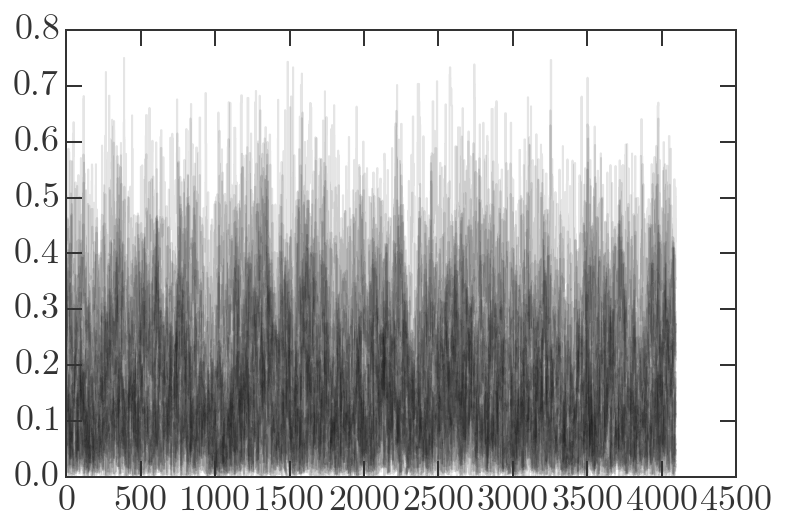

In [16]:
for i in range(sampler.chain.shape[0]):
    plt.plot(sampler.chain[i,:,4], marker=None, drawstyle='steps', color='k', alpha=0.1)

/Users/adrian/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


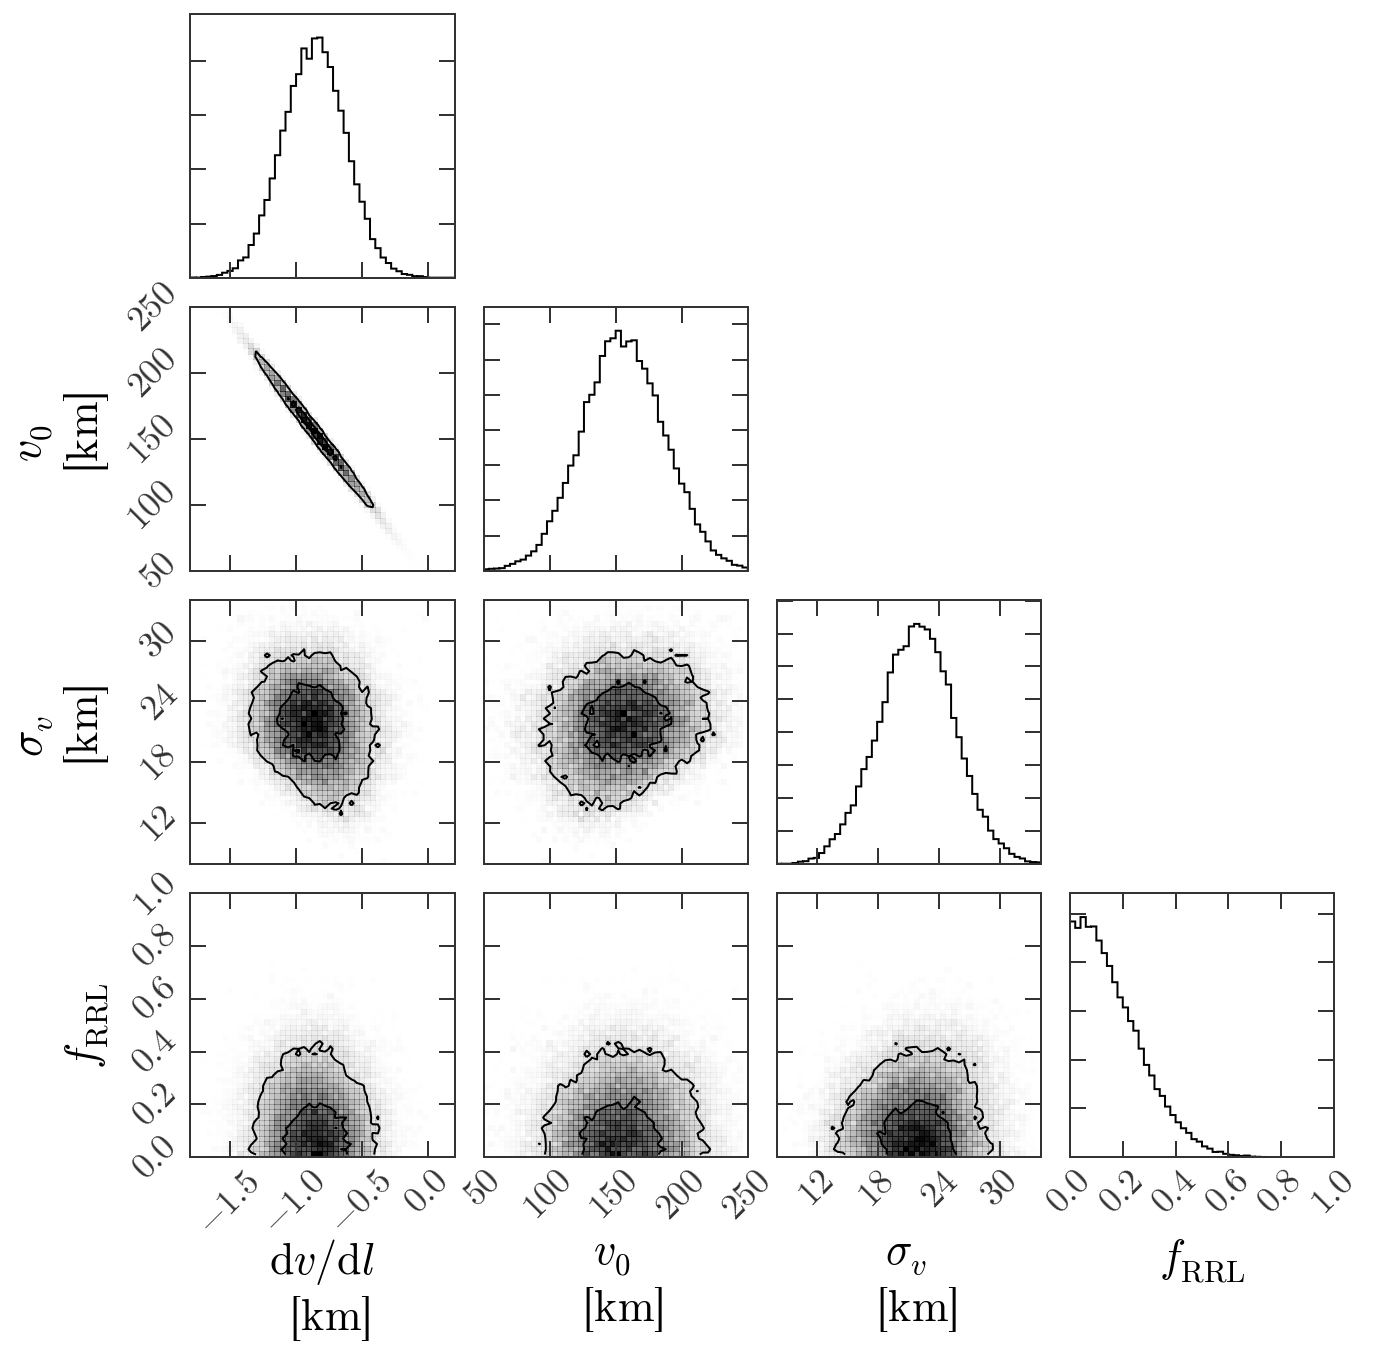

In [17]:
# labels = ['$\\mathrm{d}v/\\mathrm{d}l$ \n [${\\rm km}~{\\rm s}^{-1}~{\\rm deg}^{-1}$]', 
#           '$v_0$ \n [${\\rm km}~{\\rm s}^{-1}$]', 
#           '$\sigma_v$ \n [${\\rm km}~{\\rm s}^{-1}$]', 
#           '$f_{\\rm MG}$', '$f_{\\rm RRL}$']
# extents = [(-1.8,0.2), (50,250), (7,27), (0,1), (0,1)]

labels = ['$\\mathrm{d}v/\\mathrm{d}l$ \n [${\\rm km}~{\\rm s}^{-1}~{\\rm deg}^{-1}$]', 
          '$v_0$ \n [${\\rm km}~{\\rm s}^{-1}$]', 
          '$\sigma_v$ \n [${\\rm km}~{\\rm s}^{-1}$]', 
          '$f_{\\rm RRL}$']
extents = [(-1.8,0.2), (50,250), (8,34), (0,1)]

chchchain = np.hstack((sampler.flatchain[:,:3],sampler.flatchain[:,4:]))
fig = triangle.corner(chchchain, labels=labels, extents=extents, plot_datapoints=False)
fig.subplots_adjust(left=0.14, bottom=0.14, wspace=0.11, hspace=0.11)
# fig.savefig("/Users/adrian/projects/triand-rrlyrae/plots/posterior.pdf")

In [18]:
print(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]))
print(np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]))
print(np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2]))

(-0.86339853938748345, 0.2384867924832508)
(155.96590459672294, 31.358774074089947)
(21.754580109325236, 3.7451256622335949)


### Membership probabilities

In [19]:
map_p = sampler.flatchain[sampler.flatlnprobability.argmax()]
map_dvdl,map_v0,map_sigma_triand,map_fmg, map_frrl = map_p
map_frrl

0.016953497626984261

In [20]:
map_dvdl,map_v0,map_sigma_triand

(-0.85456039394448768, 154.65905485489748, 21.438489728995702)

In [21]:
def outlier_prob_mg(p, *args):
    dv_dl, v0, triand_sigma_v, f_mg, f_rrl = p
    p1,p2 = map(np.exp, ln_likelihood_mg(p, *args))
    return f_mg*p2 / ((1-f_mg)*p1 + f_mg*p2)

def outlier_prob_rrl(p, *args):
    dv_dl, v0, triand_sigma_v, f_mg, f_rrl = p
    p1,p2 = map(np.exp, ln_likelihood_rrl(p, *args))
    return f_rrl*p2 / ((1-f_rrl)*p1 + f_rrl*p2)

In [22]:
# mg_mem_prob = outlier_prob_mg(map_p, mgiants2['l'],mgiants2['vr'],mgiant_vr_err)
mg_mem_prob = outlier_prob_mg(map_p, mgiants2['l'],mgiants2['vgsr'],mgiants2['verr'])
rrl_mem_prob = outlier_prob_rrl(map_p, rrl_l, rrl_vgsr, rrl_verr)

ERROR: NameError: global name 'ln_likelihood_mg' is not defined [IPython.core.interactiveshell]
ERROR:astropy:NameError: global name 'ln_likelihood_mg' is not defined


NameError: global name 'ln_likelihood_mg' is not defined

### Numbers for paper

In [957]:
print(map_fmg, map_fmg * len(mgiants))
print(map_frrl, map_frrl * 141.)

(0.64166787498526823, 77.641812873217461)
(0.032264215916651739, 4.5492544442478948)


In [911]:
# print((sampler.flatchain[:,4] < 0.15).sum() / float(len(sampler.flatchain)))
# print((sampler.flatchain[:,4] < 0.29).sum() / float(len(sampler.flatchain)))

In [959]:
f_rrmg = (sampler.flatchain[:,4] * 96.) / 74

In [913]:
# f_rrmg = (sampler.flatchain[:,4] * 141.) / (sampler.flatchain[:,3] * len(mgiants))
# f_rrmg

In [971]:
onesigma = 0.265
twosigma = 0.51
print((f_rrmg < onesigma).sum() / float(len(f_rrmg)))
print((f_rrmg < twosigma).sum() / float(len(f_rrmg)))

0.682220458984
0.948120117188


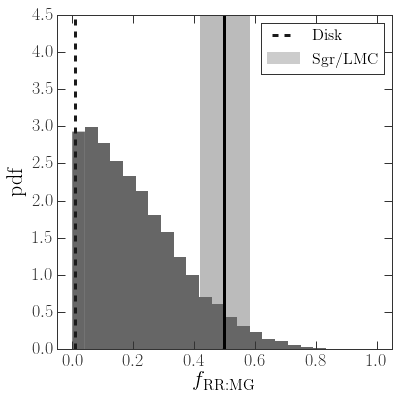

In [960]:
fig,axes = plt.subplots(1,1,figsize=(6,6))

# frrl = sampler.flatchain[:,5]
axes.hist(f_rrmg, bins=np.linspace(0,1.,25), color='#666666', normed=True);
axes.axvline(0.5, lw=3.)
# axes.axvline(onesigma, lw=2., color='r')
# axes.axvline(twosigma, lw=2., color='r')

axes.plot([0.01,0.01], [0,4.5], lw=3., linestyle='--', marker=None, label='Disk')
axes.fill_betweenx(y=np.linspace(0,4.5,5), x1=0.42, x2=0.58, color='#bbbbbb')
# hack
p2 = mpl.patches.Rectangle((0, 0), 0., 0., color='#cccccc', label='Sgr/LMC')
axes.add_patch(p2)
axes.set_xlim(-0.05,1.05)
axes.set_ylim(0, 4.5)
axes.set_xlabel(r"$f_{\rm RR:MG}$")
axes.set_ylabel(r"pdf")
axes.legend(fontsize=16)
# fig.savefig("/Users/adrian/projects/triand-rrlyrae/plots/frrmg.pdf")

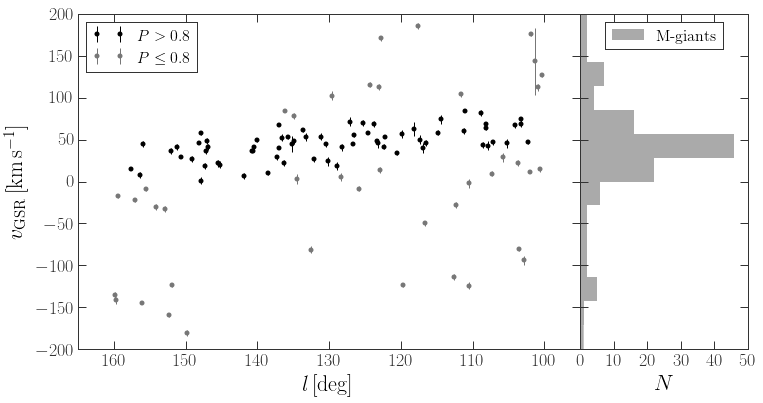

In [933]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3])

# ax1.scatter(mgiants['l'][mg_mem_prob > 0.7], mgiants['vr'][mg_mem_prob > 0.7], 
#             color='k', marker='o', s=30, label='$P>0.7$')
# ax1.scatter(mgiants['l'][mg_mem_prob <= 0.7], mgiants['vr'][mg_mem_prob <= 0.7], 
#             color='#777777', marker='o', s=15, label='$P \leq 0.7$')
ax1.errorbar(mgiants2['l'][mg_mem_prob > 0.8], mgiants2['vgsr'][mg_mem_prob > 0.8], mgiants2['verr'][mg_mem_prob > 0.8], 
             color='k', marker='o', ms=5, label='$P>0.8$', linestyle='none')
ax1.errorbar(mgiants2['l'][mg_mem_prob <= 0.8], mgiants2['vgsr'][mg_mem_prob <= 0.8], mgiants2['verr'][mg_mem_prob <= 0.8], 
             color='#777777', marker='o', ms=5, label='$P\leq 0.8$', linestyle='none')

ax1.set_xlim(165, 95)
ax1.set_xlabel(r"$l\,{\rm [deg]}$")
ax1.set_ylabel(r"$v_{\rm GSR}\,[{\rm km} \, {\rm s}^{-1}]$")

bins = np.linspace(-200, 200, 15)
ax2.hist(mgiants['vr'], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
ax2.legend(loc='upper center', fontsize=16)

ax2.set_xlabel("$N$")
ax2.yaxis.set_ticklabels([])

ax1.set_ylim(bins.min(), bins.max())
ax2.set_ylim(bins.min(), bins.max())

ax1.legend(loc='upper left', fontsize=16)

fig.subplots_adjust(wspace=0)

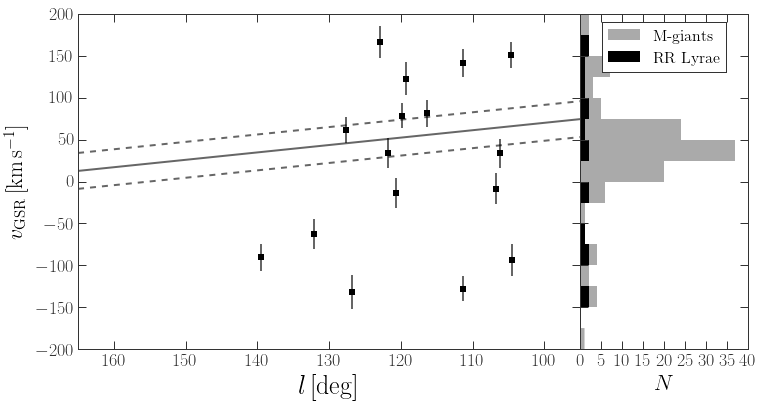

In [972]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3])

ax1.errorbar(rrl_l, rrl_vgsr, rrl_verr, linestyle='none', 
             marker='s', ms=6., color='k', ecolor='#666666', elinewidth=2)
ax1.set_xlim(165, 95)
ax1.set_xlabel(r"$l\,{\rm [deg]}$", fontsize=26)
ax1.set_ylabel(r"$v_{\rm GSR}\,[{\rm km} \, {\rm s}^{-1}]$")

# lines
ls = np.linspace(170, 90, 100)
ax1.plot(ls, map_dvdl*ls + map_v0, color='k', alpha=0.6, marker=None, linestyle='-', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 + map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 - map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)

bins = np.linspace(-200, 200, 17)
ax2.hist(mgiants['vr'], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
# ax2.hist(mgiants['vr'][high_prob_ix], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
ax2.hist(rrl_vgsr, bins=bins, orientation='horizontal', color='k', label='RR Lyrae')
ax2.legend(loc='upper center', fontsize=16)

ax2.set_xlabel("$N$")
ax2.yaxis.set_ticklabels([])

ax1.set_ylim(bins.min(), bins.max())
ax2.set_ylim(bins.min(), bins.max())

fig.subplots_adjust(wspace=0)

In [734]:
# The 4 with highest prob
all_rrl[rrl_mem_prob > 5E-2]

array([ ('TriAndRRl11', -134.61514605201003, 16.005895133275608, -133.0, 22.0, 9.262168, 38.824378, 16.8),
       ('TriAndRRl20', -123.76861320766241, 16.823395074515698, -129.0, 25.0, 5.576572, 36.203326, 16.15),
       ('TriAndRRl8', -128.0070298253975, 15.427142544303123, -128.0, 19.0, 17.992175, 35.466819, 21.18),
       ('TriAndRRl9', -157.40401688779008, 18.23900518324938, -157.0, 18.0, 11.491072, 40.199252, 18.48)], 
      dtype=[('name', 'S11'), ('Vsys', '<f8'), ('Err', '<f8'), ('v_ally', '<f8'), ('verr_ally', '<f8'), ('ra', '<f8'), ('dec', '<f8'), ('dist', '<f8')])

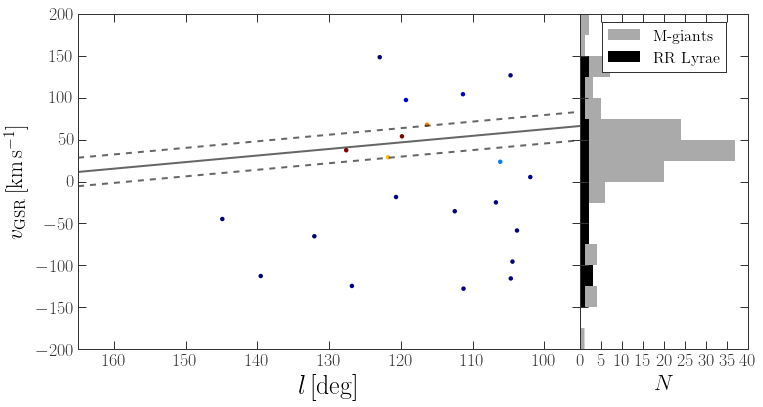

In [729]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:3])
ax2 = fig.add_subplot(gs[3])

s = ax1.scatter(rrl_l, rrl_vgsr, c=rrl_mem_prob) #, vmin=0, vmax=1.)
ax1.set_xlim(165, 95)
ax1.set_xlabel(r"$l\,{\rm [deg]}$", fontsize=26)
ax1.set_ylabel(r"$v_{\rm GSR}\,[{\rm km} \, {\rm s}^{-1}]$")

# lines
ls = np.linspace(170, 90, 100)
ax1.plot(ls, map_dvdl*ls + map_v0, color='k', alpha=0.6, marker=None, linestyle='-', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 + map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 - map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)

bins = np.linspace(-200, 200, 17)
ax2.hist(mgiants['vr'], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
# ax2.hist(mgiants['vr'][high_prob_ix], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
ax2.hist(rrl_vgsr, bins=bins, orientation='horizontal', color='k', label='RR Lyrae')
ax2.legend(loc='upper center', fontsize=16)

ax2.set_xlabel("$N$")
ax2.yaxis.set_ticklabels([])

ax1.set_ylim(bins.min(), bins.max())
ax2.set_ylim(bins.min(), bins.max())

fig.subplots_adjust(wspace=0)

### Combined figure

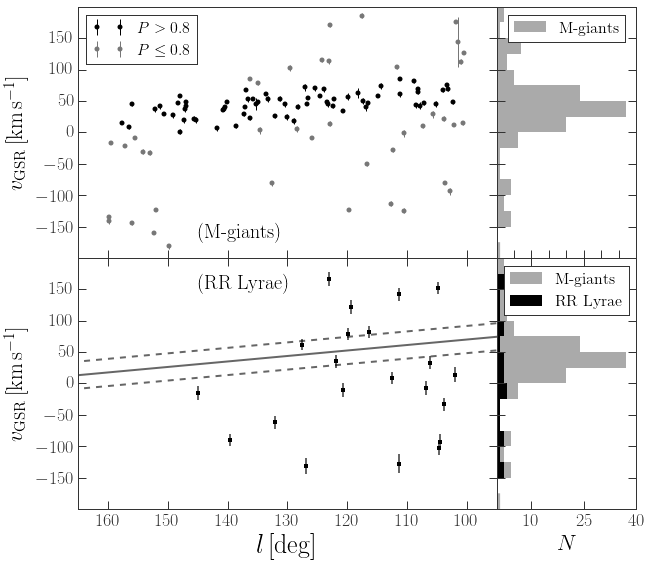

In [934]:
fig = plt.figure(figsize=(10,9))

gs = GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0,:3])
ax2 = fig.add_subplot(gs[0,3])

ax1.errorbar(mgiants2['l'][mg_mem_prob > 0.8], mgiants2['vgsr'][mg_mem_prob > 0.8], mgiants2['verr'][mg_mem_prob > 0.8], 
             color='k', marker='o', ms=5, label='$P>0.8$', linestyle='none')
ax1.errorbar(mgiants2['l'][mg_mem_prob <= 0.8], mgiants2['vgsr'][mg_mem_prob <= 0.8], mgiants2['verr'][mg_mem_prob <= 0.8], 
             color='#777777', marker='o', ms=5, label='$P\leq 0.8$', linestyle='none')

ax1.set_xlim(165, 95)
ax1.set_ylabel(r"$v_{\rm GSR}\,[{\rm km} \, {\rm s}^{-1}]$")

bins = np.linspace(-200, 200, 17)
ax2.hist(mgiants['vr'], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
ax2.legend(loc='upper center', fontsize=16)

ax1.xaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax1.yaxis.set_ticks([-150,-100,-50,0,50,100,150])

ax1.set_ylim(bins.min(), bins.max())
ax2.set_ylim(bins.min(), bins.max())

ax1.legend(loc='upper left', fontsize=16)
ax1.text(145, -175, r'(M-giants)', verticalalignment='bottom', fontsize=20)

# ------------------
# Bottom

ax1 = fig.add_subplot(gs[1,:3])
ax2 = fig.add_subplot(gs[1,3])

ax1.errorbar(rrl_l, rrl_vgsr, rrl_verr, linestyle='none', 
             marker='s', ms=4., color='k', ecolor='#666666', elinewidth=2)
ax1.set_xlim(165, 95)
ax1.set_xlabel(r"$l\,{\rm [deg]}$", fontsize=26)
ax1.set_ylabel(r"$v_{\rm GSR}\,[{\rm km} \, {\rm s}^{-1}]$")

# lines
ls = np.linspace(170, 90, 100)
ax1.plot(ls, map_dvdl*ls + map_v0, color='k', alpha=0.6, marker=None, linestyle='-', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 + map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)
ax1.plot(ls, map_dvdl*ls + map_v0 - map_sigma_triand, color='k', alpha=0.6, marker=None, linestyle='--', lw=2.)

bins = np.linspace(-200, 200, 17)
ax2.hist(mgiants['vr'], bins=bins, orientation='horizontal', color='#aaaaaa', label='M-giants')
ax2.hist(rrl_vgsr, bins=bins, orientation='horizontal', color='k', label='RR Lyrae')
ax2.legend(loc='upper center', fontsize=16)

ax2.set_xlabel("$N$")
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks([10, 25, 40])
ax1.yaxis.set_ticks([-150,-100,-50,0,50,100,150])

ax1.set_ylim(bins.min(), bins.max())
ax2.set_ylim(bins.min(), bins.max())

ax1.text(145, 175, r'(RR Lyrae)', verticalalignment='top', fontsize=20)

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("/Users/adrian/projects/triand-rrlyrae/plots/data.pdf")

# Simulated data

In [660]:
np.random.seed(8675309)
N_sim = 96
rrl_l_sim = np.random.uniform(rrl_l.min(), rrl_l.max(), size=N_sim)
rrl_vgsr_sim = np.random.normal(0., halo_dispersion, size=N_sim)
rrl_verr_sim = np.random.uniform(12, 17, size=N_sim)

args = (mgiants['l'], mgiants['vr'], mgiant_vr_err, 
        rrl_l_sim, rrl_vgsr_sim, rrl_verr_sim)

nwalkers = 32
sim_sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=5, lnpostfn=ln_posterior, args=args)

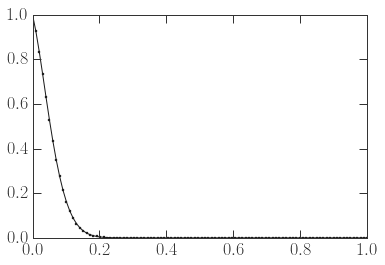

In [661]:
fs = np.linspace(0., 1., 100)
lls = np.zeros_like(fs)

for i,f in enumerate(fs):
    lls[i] = ln_posterior([-0.767, 138.96, 16.97, 73./len(mgiants), f], *args)

plt.plot(fs, np.exp(lls-lls.max()))

In [662]:
# initialize walkers
p0 = np.zeros((nwalkers,sampler.dim))
p0[:,0] = np.random.normal(-1, 0.1, size=nwalkers)
p0[:,1] = np.random.normal(150, 0.1, size=nwalkers)
p0[:,2] = np.random.normal(20, 0.5, size=nwalkers)
p0[:,3] = np.random.normal(0.5, 0.01, size=nwalkers)
p0[:,4] = np.random.normal(0.1, 0.01, size=nwalkers)

for pp in p0:
    lnp = ln_posterior(pp, *sampler.args)
    if not np.isfinite(lnp):
        print("you suck")

In [663]:
pos,prob,state = sim_sampler.run_mcmc(p0, N=128)
sim_sampler.reset()
pos,prob,state = sim_sampler.run_mcmc(pos, N=4096)

In [664]:
f_rrmg_sim = (sim_sampler.flatchain[:,4] * N_sim) / 34. 
f_rrmg_sim

array([ 0.20415766,  0.20415766,  0.20415766, ...,  0.09526477,
        0.09526477,  0.09549489])

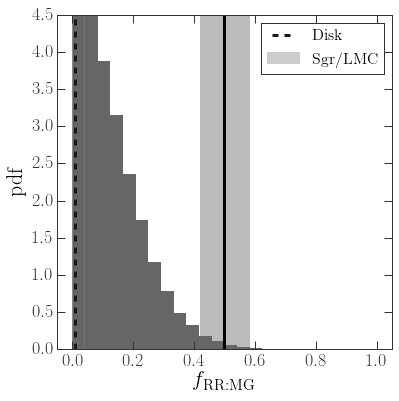

In [665]:
fig,axes = plt.subplots(1,1,figsize=(6,6))

# frrl = sampler.flatchain[:,5]
axes.hist(f_rrmg_sim, bins=np.linspace(0,1.,25), color='#666666', normed=True);
axes.axvline(0.5, lw=3.)

axes.plot([0.01,0.01], [0,4.5], lw=3., linestyle='--', marker=None, label='Disk')
axes.fill_betweenx(y=np.linspace(0,4.5,5), x1=0.42, x2=0.58, color='#bbbbbb')
# hack
p2 = mpl.patches.Rectangle((0, 0), 0., 0., color='#cccccc', label='Sgr/LMC')
axes.add_patch(p2)
axes.set_xlim(-0.05,1.05)
axes.set_ylim(0, 4.5)
axes.set_xlabel(r"$f_{\rm RR:MG}$")
axes.set_ylabel(r"pdf")
axes.legend(fontsize=16)
# fig.savefig("/Users/adrian/projects/triand-rrlyrae/plots/frrmg_sim.pdf")

---

# Bayesian evidence-ish

### M-giants

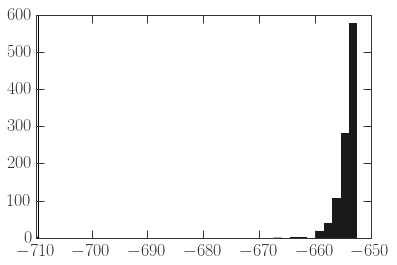

In [777]:
lnP_one_component = ln_normal(mgiants['vr'], halo_mean_v, halo_sigma_v**2 + mgiant_vr_err**2).sum()
lnP_one_component

lnP_twos = []
for i in np.random.randint(len(sampler.flatchain), size=1024):
    dvdl,v0,sigma_triand = sampler.flatchain[i,:3]
    lnP_two_components = np.logaddexp(ln_normal(mgiants['vr'], halo_mean_v, halo_sigma_v**2 + mgiant_vr_err**2),
                                      ln_normal(mgiants['vr'], v0 + dvdl*mgiants['l'], sigma_triand**2 + mgiant_vr_err**2)) - np.log(2)
    lnP_twos.append(lnP_two_components.sum())

plt.hist(lnP_twos)
plt.axvline(lnP_one_component)

Ok, so the 2 component model is muccccchhhh better

### RR Lyrae

In [778]:
lnP_one_component = ln_normal(rrl_vgsr, halo_mean_v, halo_sigma_v**2 + rrl_verr**2).sum()
lnP_one_component

-119.28576753248582

In [779]:
lnP_twos = []
for i in np.random.randint(len(sampler.flatchain), size=1024):
    dvdl,v0,sigma_triand = sampler.flatchain[i,:3]
    lnP_two_components = np.logaddexp(ln_normal(rrl_vgsr, halo_mean_v, halo_sigma_v**2 + rrl_verr**2),
                                      ln_normal(rrl_vgsr, v0 + dvdl*rrl_l, sigma_triand**2 + rrl_verr**2)) - np.log(2)
    lnP_twos.append(lnP_two_components.sum())

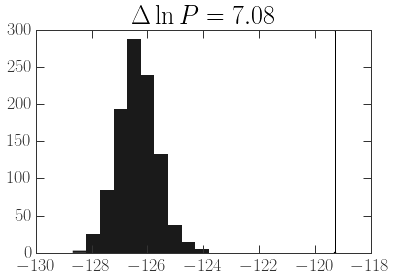

In [782]:
plt.hist(lnP_twos)
plt.axvline(lnP_one_component)
plt.title(r"$\Delta \ln P = {0:.2f}$".format(lnP_one_component - np.mean(lnP_twos)))

So the one component model is better?